# NLP Disaster Tweets

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Exploration

In [74]:
import pandas as pd
train = pd.read_csv(r"C:\Users\CL-11\OneDrive\UTS\2024AUT\NLP\DisasterTweets\NLP_disaster_tweets\train.csv")

## Distribution

In [76]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

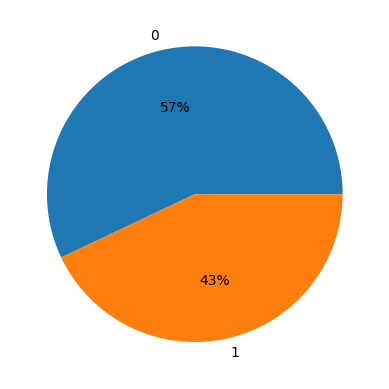

In [81]:
import matplotlib.pyplot as plt

data = train['target'].value_counts()
labels = ["0", "1"]

plt.pie(data, labels=labels, autopct='%.0f%%') 
  
# displaying chart 
plt.show() 

Fairly balanced dataset

## Common text

In [88]:
disaster_train = train[train['target'] == 1]
disaster_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Specials

In [17]:
# The keywords (may be blank)

print("{null_count} null occurences".format(null_count = sum(train['keyword'].isna())))

train['keyword'].value_counts()

61 null occurences


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [89]:
import re

pattern = re.compile(r'[^a-zA-Z0-9\s]')

special_keywords = [keyword for keyword in train['keyword'].value_counts().index if pattern.search(keyword)]

special_keyword_train = train[train['keyword'].isin(special_keywords)]

print("{special_len} occurences of special keywords".format(special_len = len(special_keyword_train)))

special_keyword_train.head()

1165 occurences of special keywords


,id,keyword,location,text,target
136,196,airplane%20accident,"19.600858, -99.047821",Experts in France begin examining airplane deb...,1
137,197,airplane%20accident,Pennsylvania,Strict liability in the context of an airplane...,1
138,198,airplane%20accident,"Salt Lake City, Utah",@crobscarla your lifetime odds of dying from a...,0
139,199,airplane%20accident,"Palo Alto, CA",Experts in France begin examining airplane deb...,1
140,201,airplane%20accident,NaN,@AlexAllTimeLow awwww they're on an airplane a...,1


In [91]:
special_keyword_train['keyword'].value_counts()[:5]

body%20bags            41
oil%20spill            38
burning%20buildings    37
nuclear%20reactor      36
dust%20storm           36
Name: keyword, dtype: int64

# Preparation

In [206]:
def clean_dataframe(df):
    cleaned = df.drop('location', axis=1) #Drop location (potentially uncessesary)

    cleaned['text'] = cleaned['text'].apply(str.lower)

    replace_unicode = lambda x : re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x)

    cleaned['text'] = cleaned['text'].apply(replace_unicode)

    remove_stopwords = lambda text : " ".join([word for word in text.split() if word not in (stop)])

    cleaned['text'] = cleaned['text'].apply(remove_stopwords)

    remove_alphanumeric = lambda text : re.sub(pattern, '', text)
    remove_spaces = lambda text : re.sub(r'\s+', ' ', text).strip()

    cleaned['text'] = cleaned['text'].apply(remove_alphanumeric)
    cleaned['text'] = cleaned['text'].apply(remove_spaces)

    #from nltk.stem import PorterStemmer
    #tokenise = lambda text : text.split(" ")
    #cleaned['text'] = cleaned['text'].apply(tokenise)
    #stemmer = PorterStemmer()
    #stem_text = lambda text: [stemmer.stem(text) for text in text]
    #cleaned['text'] = cleaned['text'].apply(stem_text)
    return cleaned

cleaned = clean_dataframe(train)
cleaned

,id,keyword,text,target
0,1,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,forest fire near la ronge sask canada,1
2,5,NaN,residents asked shelter place notified officer...,1
3,6,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...
7608,10869,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,NaN,volcano hawaii,1
7611,10872,NaN,police investigating ebike collided car little...,1


In [269]:
X = cleaned.drop('target', axis=1)
y = cleaned.drop(list(X.columns), axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X['text'])

tfidf_matrix

<7613x16385 sparse matrix of type '<class 'numpy.float64'>'
	with 65806 stored elements in Compressed Sparse Row format>

# NLP Model

## Training and predicting

In [293]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X_train, X_valid, y_train, y_valid = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

def get_model(X_train, y_train):
    model = MultinomialNB()
    return model

def train(X_train, y_train):
    model = get_model(X_train, y_train)

    # Train a classifier, for example, Naive Bayes
    model.fit(X_train, y_train)

    return model

model = train(X_train, y_train)

predictions = model.predict(X_valid)

# Evaluate the model
print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



c:\Python39\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Exploration of features

In [240]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

# Get feature names to see the term each column corresponds to
feature_names = tfidf_vectorizer.get_feature_names_out()

# Find the highest TF-IDF scores for the first document
doc = 0  # First document
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

print("Top terms in first document:")
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w, s)


NotFittedError: Vocabulary not fitted or provided

### Similarity

In [198]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between the first document and all documents (including itself)
cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix).flatten()

# Find the document most similar to the first one
most_similar_doc = cosine_similarities.argsort()[-2]  # -1 is the document itself

print(f"Document {most_similar_doc} is most similar to document 0 with a score of {cosine_similarities[most_similar_doc]}")

print("DOC 0 : {doc_text}".format(
    doc_text = cleaned.iloc[int(0)]['text']))

print("DOC {most_similar_doc} : {most_similar_doc_text}".format(
    most_similar_doc=most_similar_doc, 
    most_similar_doc_text = cleaned.iloc[int(most_similar_doc)]['text']))


Document 4010 is most similar to document 0 with a score of 0.2415702530696119
DOC 0 : deeds reason earthquake may allah forgive us
DOC 4010 : may allah help suffering pakistan floods families dua


### Feature Reduction

In [183]:
from sklearn.decomposition import TruncatedSVD

# Reduce the dimensionality of tfidf_matrix
svd = TruncatedSVD(n_components=100)  # Example reduction to 100 dimensions
reduced_features = svd.fit_transform(tfidf_matrix)

# Now, reduced_features can be used as inputs for your models

### Visualisation

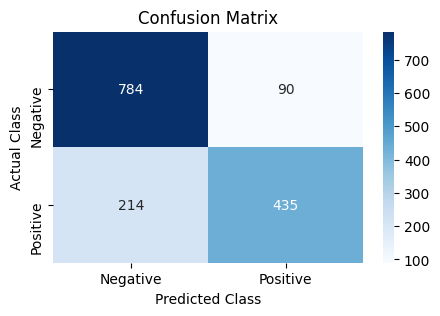

In [298]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_valid, predictions)

# Plotting using Seaborn
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


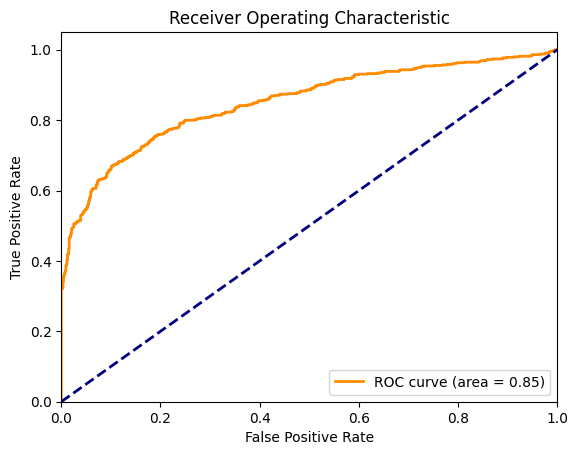

In [301]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores_proba = model.predict_proba(X_valid)
y_scores = y_scores_proba[:, 1]

# Assuming `y_true` are your true binary labels and `y_scores` are the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


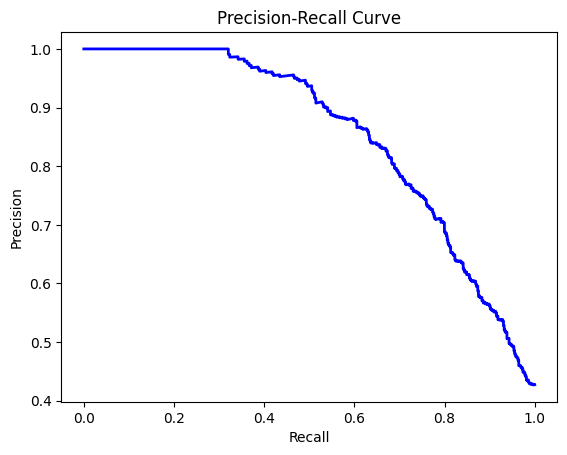

In [303]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming `y_true` and `y_scores` as before
precision, recall, _ = precision_recall_curve(y_valid, y_scores)

plt.figure()
plt.plot(recall, precision, lw=2, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


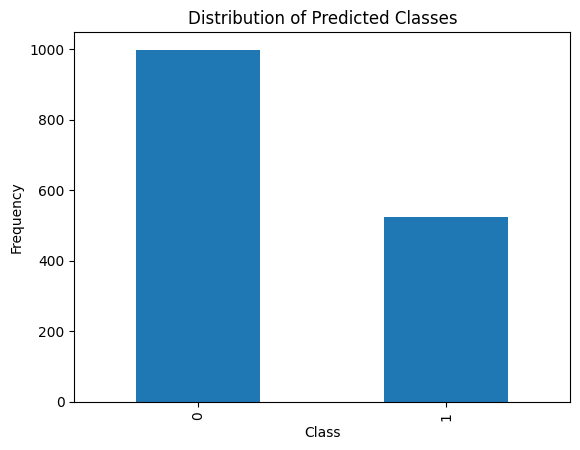

In [305]:
import pandas as pd

# Assuming `predictions` is a list or array of your model's predictions
predictions_series = pd.Series(predictions)

# Plotting the distribution of predictions
predictions_series.value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Classes')
plt.show()



## Testing

In [287]:
test = pd.read_csv(r"C:\Users\CL-11\OneDrive\UTS\2024AUT\NLP\DisasterTweets\NLP_disaster_tweets\test.csv")
cleaned_test = clean_dataframe(test)
cleaned_test.head()

,id,keyword,text
0,0,NaN,happened terrible car crash
1,2,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,apocalypse lighting spokane wildfires
4,11,NaN,typhoon soudelor kills china taiwan


In [306]:
X_test_tfidf = tfidf_vectorizer.transform(cleaned_test['text'])
test_predictions = model.predict(X_test_tfidf)
test_predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

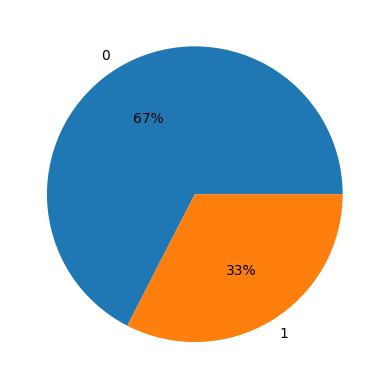

In [331]:
zero_count = np.unique(test_predictions, return_counts=True)[1][0]
one_count = np.unique(test_predictions, return_counts=True)[1][1]

data = [zero_count, one_count]
labels = ["0", "1"]

plt.pie(data, labels=labels, autopct='%.0f%%') 
  
# displaying chart 
plt.show() 

In [333]:
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [332]:
test_predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [340]:
output = cleaned_test[['id']]
output['target'] = test_predictions
output

C:\Users\CL-11\AppData\Local\Temp\ipykernel_17956\4117979935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['target'] = test_predictions


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [347]:
output.to_csv(r'C:\Users\CL-11\OneDrive\UTS\2024AUT\NLP\DisasterTweets\NLP_disaster_tweets\output.csv', index=False)

In [348]:
pd.read_csv(r'C:\Users\CL-11\OneDrive\UTS\2024AUT\NLP\DisasterTweets\NLP_disaster_tweets\output.csv')

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1
